In [2]:
import numpy as np
from scipy.io import mminfo,mmread
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import inv, eig
from numpy import pi

from scipy.signal import find_peaks_cwt

# Load system matrices as sparse-matrices
Here we use the [sparse module of scipy](
https://docs.scipy.org/doc/scipy/reference/sparse.html).
The module contains functions for linear algebra with sparse matrices (scipy.sparse.linalg).
Do **not** mix with numpy functions! Convert thme to dense arrays using `.toarray()` if you need numpy.

In [3]:
from scipy import sparse
# load the system matrices from last time
M = sparse.csc_matrix(mmread('Ms.mtx'))#.toarray() # mass matrix
K = sparse.csc_matrix(mmread('Ks.mtx'))#.toarray() # stiffness matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes
C = sparse.csc_matrix(K.shape) # a zeros damping matrix
N = X.shape[0] # number of nodes

In [4]:
# for plotting
nprec = 6 # precision for finding uniqe values
# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
xv = np.unique(np.round(X[:,0],decimals=nprec))
yv = np.unique(np.round(X[:,1],decimals=nprec))
zv = np.unique(np.round(X[:,2],decimals=nprec))

In [5]:
# select nodes on the west-side, i.e. at x=x_min
tol = 1e-12
x_min = X[:,0].min()
Nw = np.argwhere(np.abs(X[:,0]-x_min)<tol) # Node indices of West-Edge nodes

# select node on North-East-Top corner
Nnet = np.argwhere(np.all(np.abs(X-X.max(axis=0))<tol,axis=1))[0]

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nw],Iy[Nw],Iz[Nw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

In [6]:
# compute the reduced system
Kc = sparse.csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = sparse.csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = sparse.csc_matrix(C[np.ix_(~Ic,~Ic)])

# Compute Natural Frequencies and Mode Shapes
We use the routines for sparce matrices.

In [7]:
k = 15
Wc,Vc = sparse.linalg.eigsh(Kc,k,Mc,sigma=0.0)
V = np.zeros([3*N,k])
V[~Ic,:] = Vc
naturalFreq = np.sqrt(Wc)/2/np.pi
print(naturalFreq)


[   5.41365167    6.12150091   34.03458185   34.87519056   80.76936295
   95.99644165   96.71563971  100.24150102  106.7442411   140.75242428
  190.35877089  191.02723327  217.61704478  256.76651141  280.93000138]


## Aminations

You can use the excellent [JSanimation](https://github.com/jakevdp/JSAnimation) package to show matplotlib animations in an ipython notebook.
To install it get the package from github and install it
```
cd
git clone https://github.com/jakevdp/JSAnimation.git
cd JSAnimation
python setup.py install --user
```


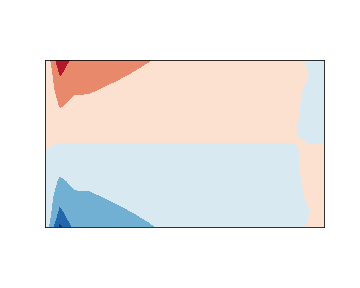
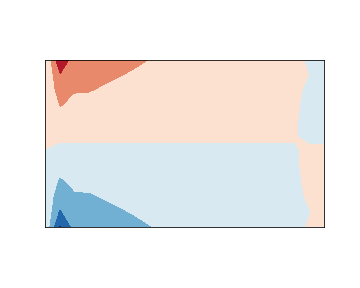
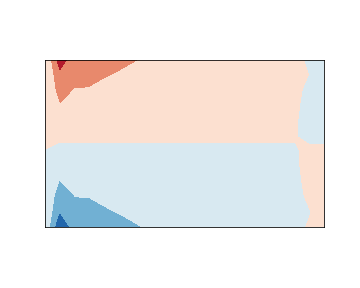
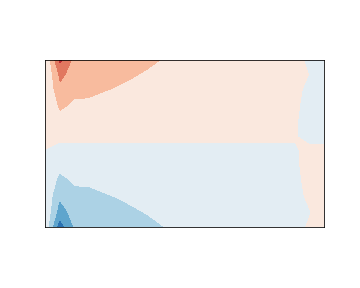
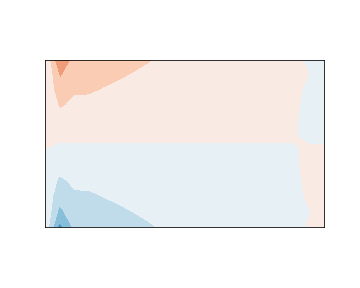
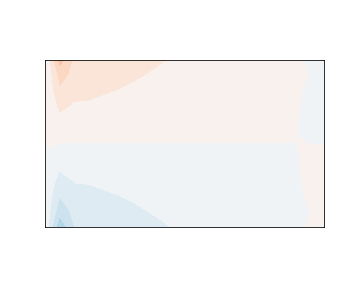
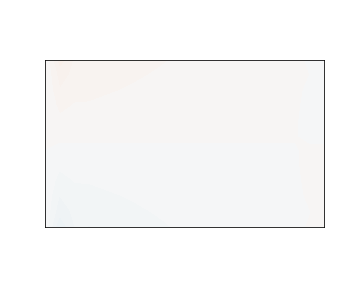
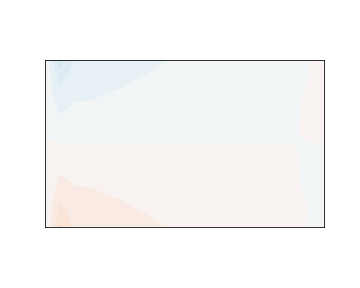
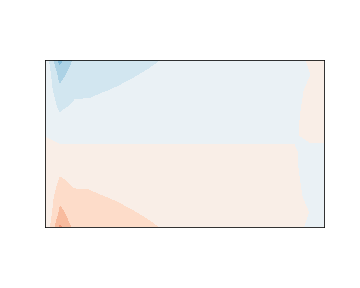
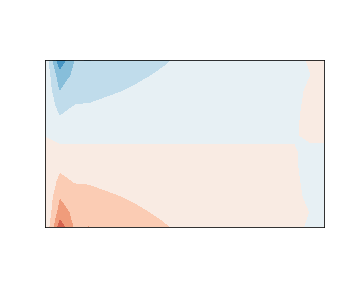
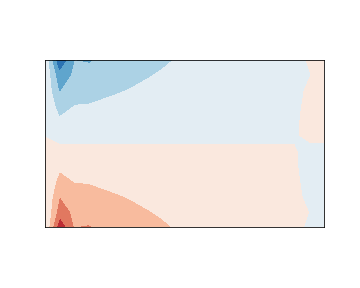
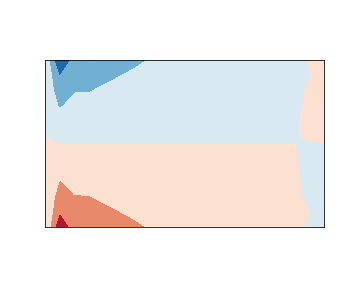
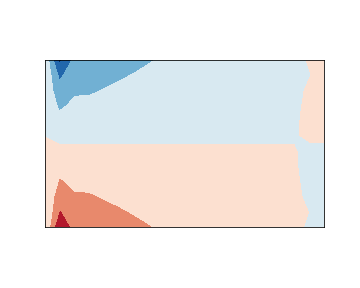
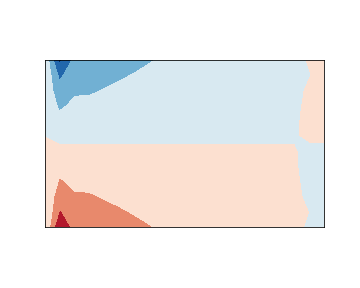
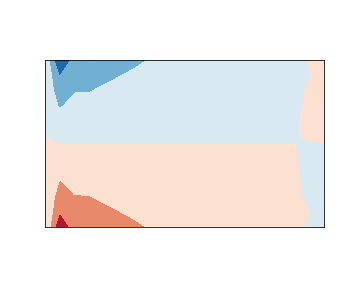
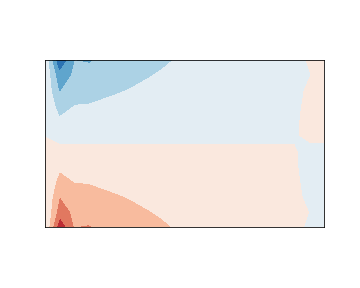
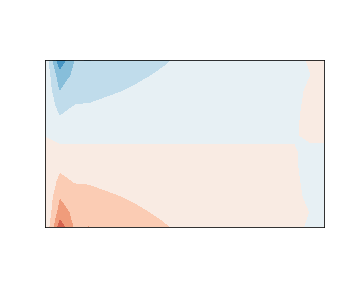
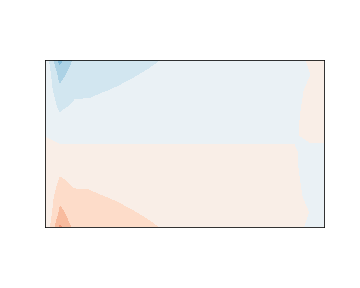
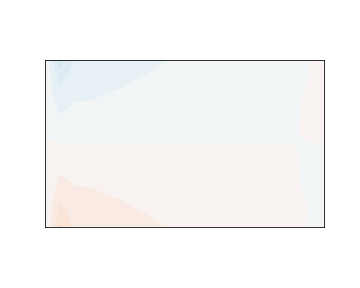
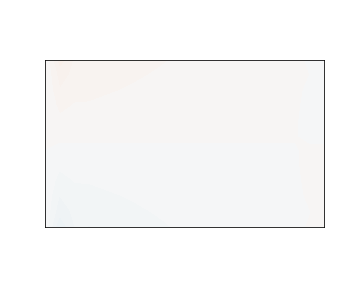
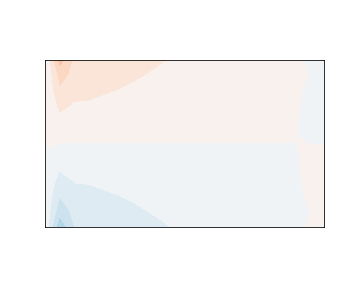
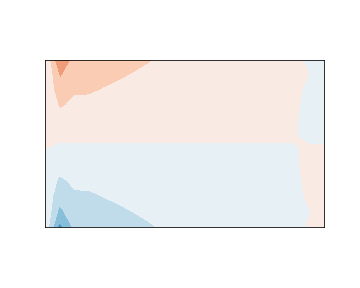
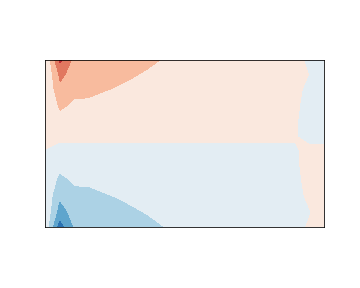
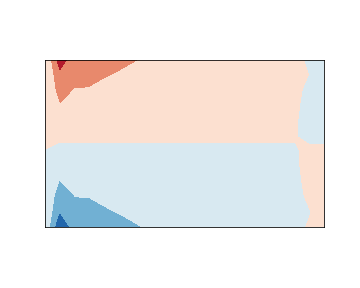
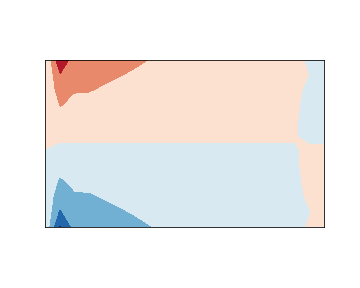

In [70]:
from JSAnimation import IPython_display # this will render objects of type 'matplotlib.animation.FuncAnimation'

def animateHarmonic(u):
    """
    This function will use one mode shape vector of global DoFs, select the z-dofs for nodes on the 
    top surface (Nt) and return an animation of contour plots.
    """
    from matplotlib import animation
    from matplotlib.pyplot import subplots
    # select the data to plot (z-displacement of top nodes)
    Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol)
    c = np.reshape(u[Iz[Nt]],[len(yv),len(xv)]) # color matrix with dim (y,x,t)

    # set limit
    lim = np.max(np.abs(c))

    # setup figure
    fig,ax = subplots(figsize=[5,4])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # animate function is called for each 'frame' (input is frames[i])
    def animate(phi):
        c_t = (c[:,:]*np.exp(1j*phi)).real # select the current data for time step i
        cf = ax.contourf(xv,yv,c_t,cmap=plt.get_cmap('RdBu'),vmin=-lim,vmax=lim)
        return cf

    # create animation (may take long for many frames)
    return animation.FuncAnimation(fig, animate, frames=np.linspace(0,2*np.pi,25,endpoint=False), interval=1000/25)

animateHarmonic(V[:,4])

# Newmark Method for Time Integration
Here we use the Newmark method for the time integration.
Given the algorithm parameters and a time step one can compute the matrix-factorization for the predictor step.
In every time step we then
1. assemble the rhs
2. solve a linear system
3. update the solution

In [102]:
# Newmark Method for the time integration
# can you extend it to the Hilbert-Hughs-Taylor mathod?
gamma = 0.5 # >= 1/2 for unconditional stability
beta = 0.25 # >= (1/2+gamma)**2/4 for unconditional stability
print(beta,((1./2.+gamma)**2)/4)

dt = 0.003 # time step
a0 = 1./(beta*dt**2)
a1 = gamma/(beta*dt)
a2 = 1./(beta*dt)
a3 = 1./(2.*beta) - 1.
a4 = gamma/beta - 1.
a5 = dt/2.*(gamma/beta - 2.0)
a6 = dt*(1.0-gamma)
a7 = gamma*dt

Cc = 0.1*Mc
Kn = Kc + a0*Mc + a1*Cc
# compute the factorisation
solve_step = sparse.linalg.factorized(Kn)

0.25 0.25


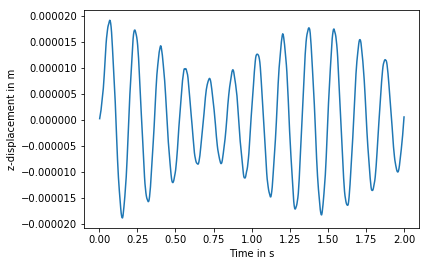

In [103]:
# setup time vector
T = 2
t = np.arange(dt,T,dt)

#  set forcing on a single node
Ts = 0.05
k = 4
f = np.zeros([3*N,len(t)])
#f[Iz[Nnet],:] = 1-np.exp(-(t/Ts)**k) # step function
f[Iz[Nnet],:] = np.exp(-(t/Ts)**k) # impulse function

# initialize (in the constraint system)
ut = np.zeros([np.sum(~Ic)]) # initial displacement
vt = np.zeros_like(ut) # initial velocity
at = np.zeros_like(ut) # initial acceleration

# preallocate result ( in full system )
x = np.zeros([3*N,len(t)])

# do the time integration
for i in range(len(t)) :
    # compute effective forcing vector
    ft1 = f[~Ic,i] + Mc*(a0*ut + a2*vt + a3*at) + Cc*(a1*ut + a4*vt + a5*at )   
    # solve for u at t+dt using the pre-factorized matrix
    ut1 = solve_step(ft1)
    # update v & a
    at1 = a0*(ut1-ut) - a2*vt - a3*at
    vt1 = vt + a6*at + a7*at1
    # save and prepare next step
    x[~Ic,i] = ut1
    ut = ut1
    vt = vt1
    at = at1

# plot time result
fig,ax = plt.subplots()
ax.plot(t,x[Iz[Nnet],:].T)
ax.set_xlabel('Time in s')
ax.set_ylabel('z-displacement in m')


## FFT of the above signal

[ 6.00600601  5.50550551  6.50650651  5.00500501  7.00700701]
[   6.00600601   34.03403403   61.56156156   80.08008008   98.5985986
  116.61661662  119.11911912  130.13013013  136.63663664  145.64564565
  152.65265265  164.66466466]
natural freq:
[  5.41365167   6.12150091  34.03458185  34.87519056]


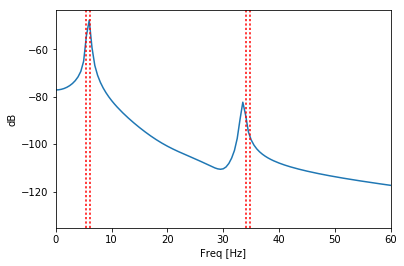

In [108]:
signal=x[Iz[Nnet],:].T
#signal=f[Iz[Nnet],:].T # freq-comp of the excitation signal
signal=signal[:,0] # needed to change the array from 2D to 1D
#signal= 1.*np.sin(10*2*np.pi*t)+1.*np.sin(5*2*np.pi*t) +1 # test signal mit 5Hz und 10Hz
fourier= np.fft.fft(signal)
freq = np.fft.fftfreq(len(t),dt)

posfreq=freq>=0
posfourier=np.abs(fourier[posfreq])

# plot time result
fig1,ax1 =plt.subplots()

ax1.plot(freq[posfreq],20*np.log10(posfourier))
ax1.set_xlabel('Freq [Hz]')
ax1.set_ylabel('dB')
ax1.set_xlim(0,60)

# plot the natural frequencies
xcoords = naturalFreq[:4]
for xc in xcoords:
    plt.axvline(x=xc, color='r', ls=':')


max_freqs = freq[np.argsort(posfourier)[::-1][:5]] #returns the 5 highest Freq-Comp (NOT PEAKS)
print(max_freqs)
peakIndex = find_peaks_cwt(posfourier,np.arange(1, 15)) # find some peaks (most likely will miss the second peak close to 1st)
print(freq[peakIndex])

print('natural freq:')
print(naturalFreq[:4])

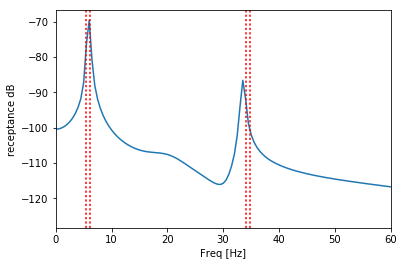

In [119]:
signal=f[Iz[Nnet],:].T # freq-comp of the excitation signal
signal=signal[:,0] # needed to change the array from 2D to 1D
#signal= 1.*np.sin(10*2*np.pi*t)+1.*np.sin(5*2*np.pi*t) +1 # test signal mit 5Hz und 10Hz
fourier_anreg= np.fft.fft(signal)
freq = np.fft.fftfreq(len(t),dt)

receptance_td = np.abs(fourier[posfreq])/np.abs(fourier_anreg[posfreq])
# plot time result
fig1,ax1 =plt.subplots()

ax1.plot(freq[posfreq],20*np.log10(receptance_td))
ax1.set_xlabel('Freq [Hz]')
ax1.set_ylabel('receptance dB')
ax1.set_xlim(0,60)

# plot the natural frequencies
xcoords = naturalFreq[:4]
for xc in xcoords:
    plt.axvline(x=xc, color='r', ls=':')

# Compute the Steady-State Response

1. Compute the dynamic stiffness matrix for one $\omega$
2. assemble one (or serveral) sorcing fectors
3. solve for the displaxements


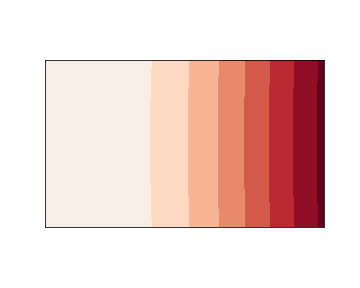
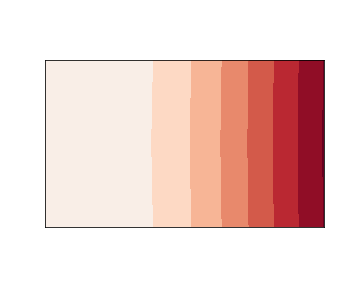
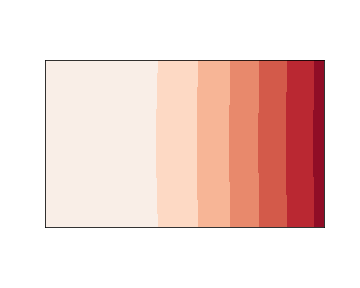
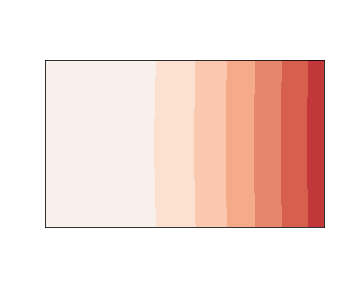
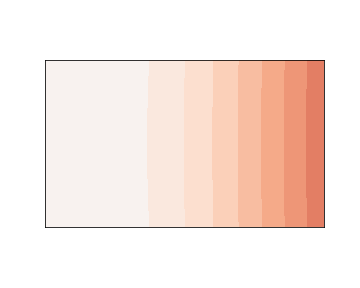
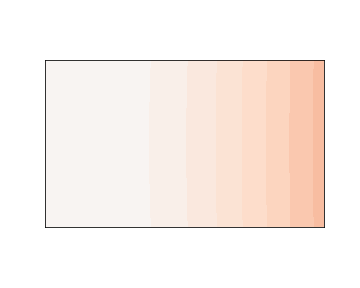
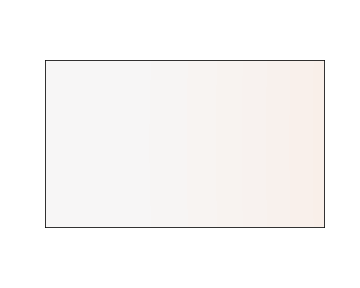
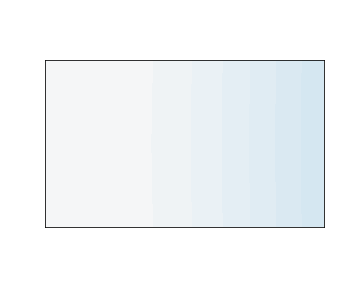
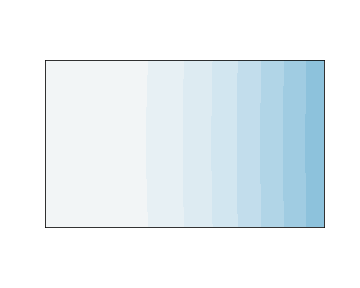
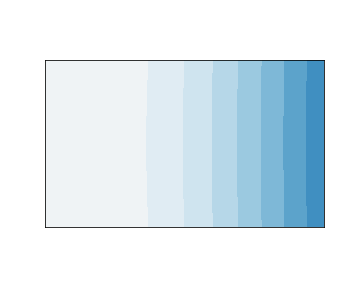
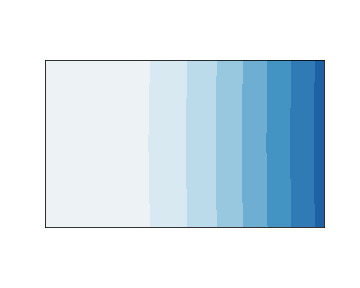
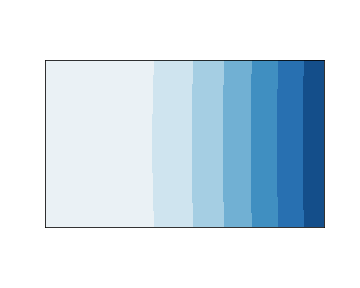
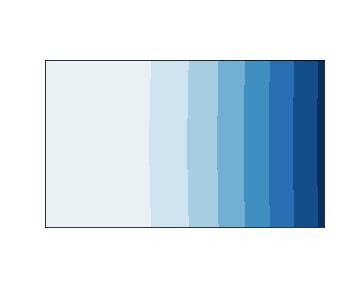
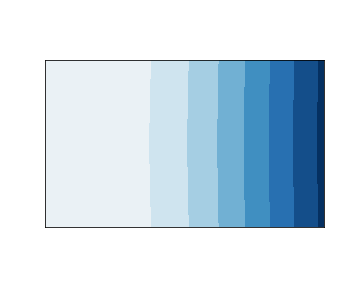
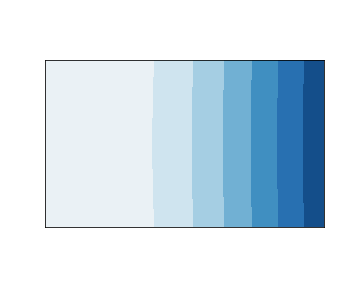
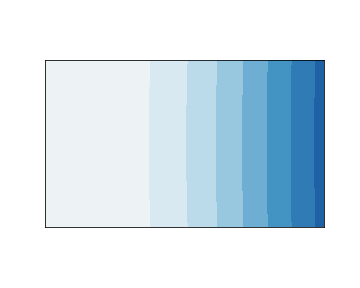
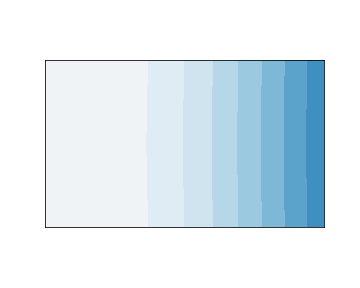
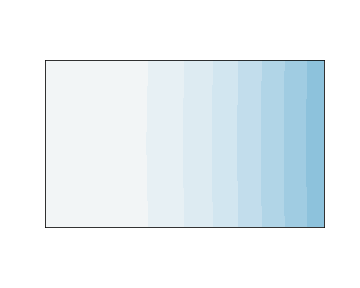
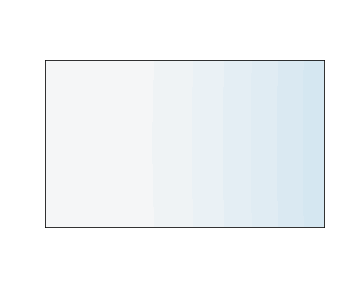
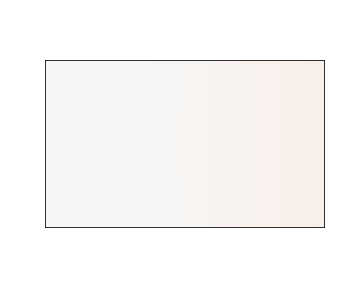
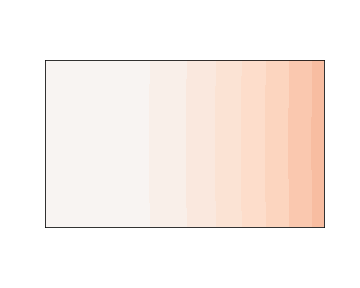
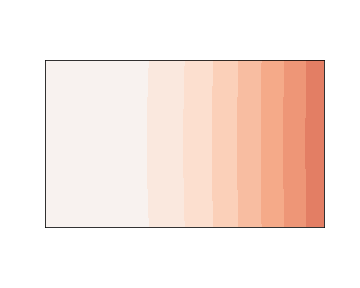
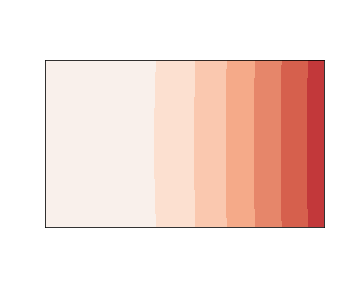
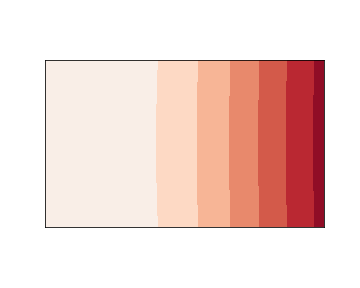
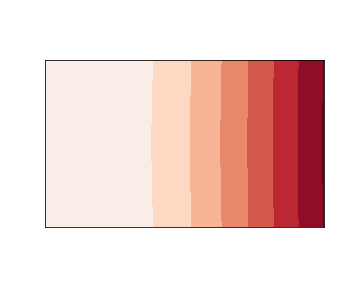

In [36]:
# plot the geometric points 
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial

pt = [0,0,0]
distance,center_index = spatial.KDTree(X).query(pt)


w = 90.
fw = np.ones([3*N]) # put force on all nodes ...
Zw = Kc + 1j*w*Cc - w**2 * Mc
xw = np.zeros(3*N,dtype=complex)
xw[~Ic] = sparse.linalg.spsolve(Zw,fw[~Ic])
animateHarmonic(xw)

In [63]:
# center point
tf = {}
for i, w in enumerate(range(5,41)):
    fw = np.zeros([3*N]) 
    fw[Iz[Nnet]]=1 # put force on North-East-Top corner
    Zw = Kc + 1j*2*np.pi*w*Cc - (2*np.pi*w)**2 * Mc
    xw = np.zeros(3*N,dtype=complex)
    xw[~Ic] = sparse.linalg.spsolve(Zw,fw[~Ic])
    tf[w] = np.abs(xw[center_index])
    #animateHarmonic(xw)


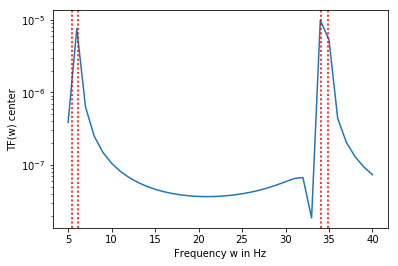

In [65]:
fig,ax = plt.subplots()
data_x = sorted([w for w in tf])
data_y = [tf[w] for w in data_x]
ax.semilogy(data_x, data_y)
ax.set_xlabel('Frequency w in Hz')
ax.set_ylabel('TF(w) center')

# plot the natural frequencies
xcoords = naturalFreq[:4]
for xc in xcoords:
    plt.axvline(x=xc, color='r', ls=':')

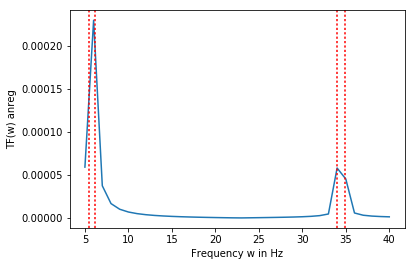

In [67]:
# anregungspunkt
tf = {}
for i, w in enumerate(range(5,41)):
    # w = 34.
    fw = np.zeros([3*N]) 
    fw[Iz[Nnet]]=1 # put force on North-East-Top corner
    Zw = Kc + 1j*2*np.pi*w*Cc - (2*np.pi*w)**2 * Mc
    xw = np.zeros(3*N,dtype=complex)
    xw[~Ic] = sparse.linalg.spsolve(Zw,fw[~Ic])
    tf[w] = np.abs(xw[Iz[Nnet]])
    #animateHarmonic(xw)
    
fig,ax = plt.subplots()
data_x = sorted([w for w in tf])
data_y = [tf[w] for w in data_x]
ax.semilogy(data_x, data_y)
ax.set_xlabel('Frequency w in Hz')
ax.set_ylabel('TF(w) anreg')

# plot the natural frequencies
xcoords = naturalFreq[:4]
for xc in xcoords:
    plt.axvline(x=xc, color='r', ls=':')

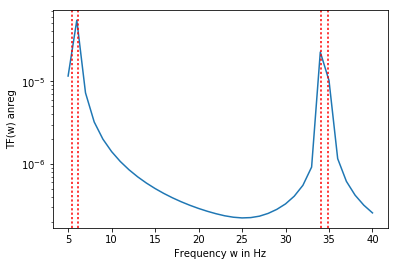

In [111]:
# alle gemittelt
tf = {}
for i, w in enumerate(range(5,41)):
    # w = 34.
    fw = np.zeros([3*N]) 
    fw[Iz[Nnet]]=1 # put force on North-East-Top corner
    Zw = Kc + 1j*2*np.pi*w*Cc - (2*np.pi*w)**2 * Mc
    xw = np.zeros(3*N,dtype=complex)
    xw[~Ic] = sparse.linalg.spsolve(Zw,fw[~Ic])
    tf[w] = sum(np.abs(xw[Iz]))/len(xw)*3
    #animateHarmonic(xw)
    
fig,ax = plt.subplots()
data_x = sorted([w for w in tf])
data_y = [tf[w] for w in data_x]
ax.semilogy(data_x, data_y)
ax.set_xlabel('Frequency w in Hz')
ax.set_ylabel('TF(w) anreg')

# plot the natural frequencies
xcoords = naturalFreq[:4]
for xc in xcoords:
    plt.axvline(x=xc, color='r', ls=':')

In [221]:
# punkt 7

# alle gemittelt
tf_1 = {}
for i, w in enumerate([5,6]):
    # w = 34.
    fw = np.zeros([3*N]) 
    fw[Iz[Nnet]]=1 # put force on North-East-Top corner
    Zw = Kc + 1j*2*np.pi*w*Cc - (2*np.pi*w)**2 * Mc
    Hw = sparse.linalg.inv(Zw)
    
    Hw_extract = Hw.toarray()[:, np.argwhere(fw[~Ic])[0,0]]
    Hw_extract = Hw_extract[np.arange(1140)*3+2]
    tf_1[w] = sum(np.abs(Hw_extract))/len(Hw_extract)


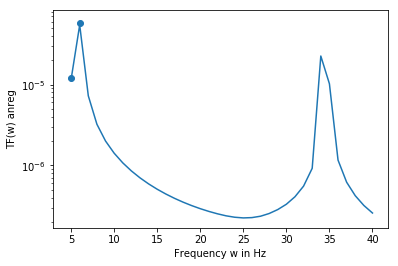

In [222]:
fig,ax = plt.subplots()
data_x = sorted([w for w in tf])
data_y = [tf[w] for w in data_x]

ax.semilogy(data_x, data_y)

data_x = sorted([w for w in tf_1])
data_y = [tf_1[w] for w in data_x]
ax.set_xlabel('Frequency w in Hz')
ax.set_ylabel('TF(w) anreg')
ax.scatter(data_x, data_y)


In [218]:
    Hw_extract = Hw.toarray()[:, np.argwhere(fw[~Ic])[0,0]]
    Hw_extract = Hw_extract[np.arange(1140)*3+2]
    Hw_extract.shape

(1140,)

In [203]:
Hw.shape
voll=[False] * N * 3
for i, el in enumerate(voll):
    if i in Iz:
        voll[i] = True

delete_ind = []
neu_voll = []
for i, el in enumerate(voll):
    if not Ic[i]:
        neu_voll.append(voll[i])


Ic

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [200]:
Ic[Iz].shape

(1200,)